In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
import os 
import cv2
import numpy as np

In [26]:
trainDir = r"/home/trojan/Desktop/dimentia/data_10slices/dataset with PGGAN/train"
#trainDir2 = r"/home/trojan/Desktop/dimentia/data_10slices/edge_data/train"
input_shape = Input(shape=(256, 256, 3))
#input_shape2 = Input(shape=(256, 256, 1))
dropout_rate = 0.2
batch_size = 16
height, width = 256, 256

In [27]:
def lr_schedule(epoch):
    lr = 1e-3 #1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 80:
        lr *= 1e-3
    elif epoch > 40: # 120
        lr *= 1e-2
    elif epoch > 20: #80
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [28]:
train_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.2)
train_generator = train_datagen.flow_from_directory(trainDir, target_size=(height, width), batch_size=batch_size, 
                                                    class_mode='categorical', color_mode='rgb',
                                                   subset='training')

validation_generator = train_datagen.flow_from_directory(trainDir, target_size=(height, width), batch_size=batch_size,
                                                     class_mode='categorical', color_mode='rgb',
                                                        subset='validation')

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

Found 15743 images belonging to 2 classes.
Found 3934 images belonging to 2 classes.


In [29]:
canny = tf.image.sobel_edges(input_shape)
cnn_top = Conv2D(32, (5,5), padding='same', activation='relu')(canny)
cnn_top = BatchNormalization()(cnn_top)
cnn_top = MaxPooling2D(pool_size=(2, 2))(cnn_top)
cnn_top = Conv2D(64, (3,3), padding='same', activation='relu')(cnn_top)
cnn_top = BatchNormalization()(cnn_top)
cnn_top = MaxPooling2D(pool_size=(2, 2))(cnn_top)
cnn_top = Conv2D(128, (3,3), padding='same', activation='relu')(cnn_top)
cnn_top = BatchNormalization()(cnn_top)
cnn_top = MaxPooling2D(pool_size=(2, 2))(cnn_top)
cnn_top = Conv2D(256, (3,3), padding='same', activation='relu')(cnn_top)
cnn_top = BatchNormalization()(cnn_top)
cnn_top = MaxPooling2D(pool_size=(2, 2))(cnn_top)
cnn_top = Conv2D(512, (3,3), padding='same', activation='relu',)(cnn_top)
cnn_top = BatchNormalization()(cnn_top)
cnn_top = MaxPooling2D(pool_size=(2, 2))(cnn_top)
cnn_top = Flatten()(cnn_top)
cnn_top = Dense(256)(cnn_top)
cnn_top = Dropout(dropout_rate)(cnn_top)
cnn_top = Dense(128)(cnn_top)
cnn_top = Dropout(dropout_rate)(cnn_top)
cnn_top = Dense(2)(cnn_top)
output = Activation('softmax')(cnn_top)

ValueError: Input 0 of layer max_pooling2d_1 is incompatible with the layer: expected ndim=4, found ndim=5. Full shape received: [None, 256, 256, 3, 32]

In [24]:
model = Model(input_shape, output)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr_schedule(0)),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

NameError: name 'output' is not defined

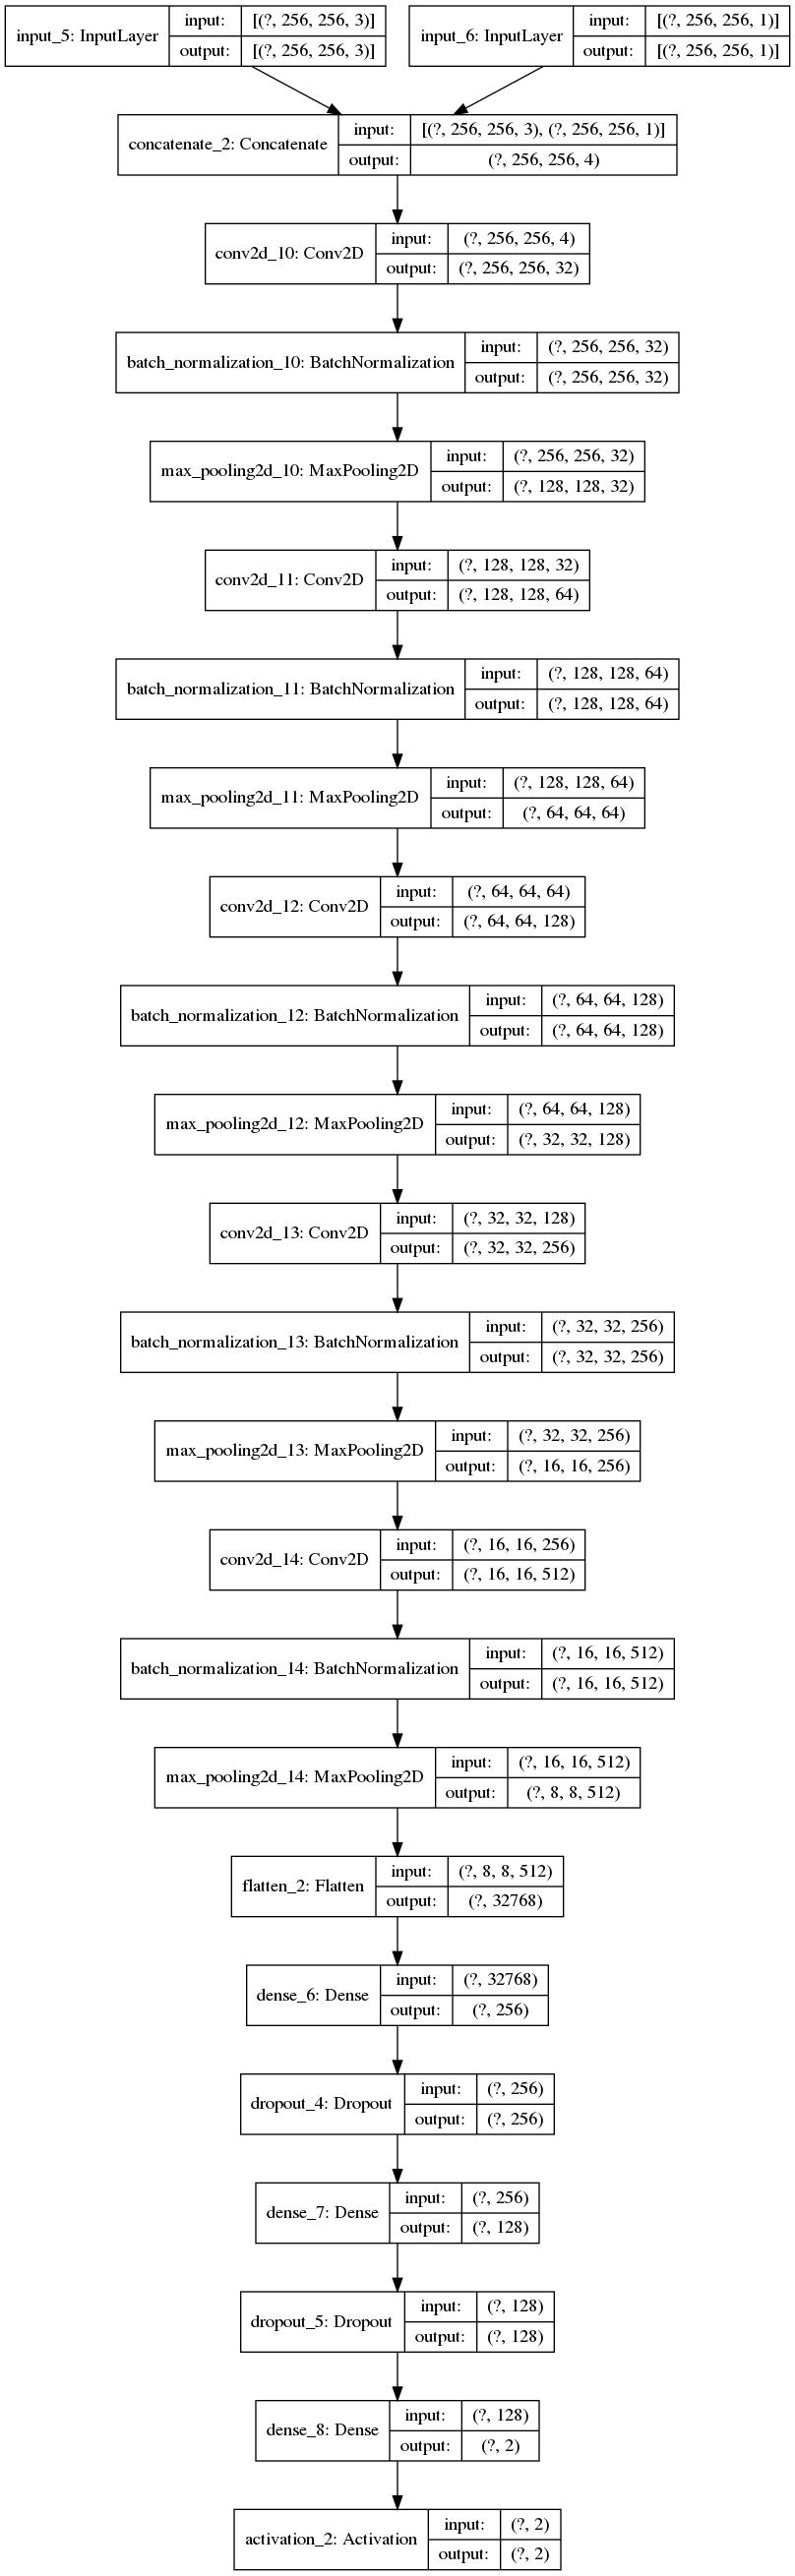

In [27]:
tf.keras.utils.plot_model(model, to_file='my_model.png', show_shapes=True)

In [28]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_sparse_categorical_accuracy', mode='max', verbose=1, save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

In [30]:
model.fit_generator(train_generator, steps_per_epoch=STEP_SIZE_TRAIN, epochs=50,
                          validation_data=validation_generator, verbose=1, workers=1, 
                          validation_steps=STEP_SIZE_VALID, callbacks=checkpoint)

Found 15743 images belonging to 2 classes.
Found 15743 images belonging to 2 classes.
Epoch 1/3
984/984 [==============================] - ETA: 0s - loss: 0.2711 - sparse_categorical_accuracy: 0.9988Found 3934 images belonging to 2 classes.
Found 3934 images belonging to 2 classes.

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.50000, saving model to best_model.h5
984/984 [==============================] - 56s 57ms/step - loss: 0.2711 - sparse_categorical_accuracy: 0.9988 - val_loss: 2744.8467 - val_sparse_categorical_accuracy: 0.5000
Epoch 2/3
983/984 [============================>.] - ETA: 0s - loss: 35.3597 - sparse_categorical_accuracy: 0.9956
Epoch 00002: val_sparse_categorical_accuracy did not improve from 0.50000
984/984 [==============================] - 54s 55ms/step - loss: 35.3260 - sparse_categorical_accuracy: 0.9956 - val_loss: 8940.2646 - val_sparse_categorical_accuracy: 0.5000
Epoch 3/3
983/984 [============================>.] - ETA: 0s - loss: 76.

In [31]:
from tensorflow.keras.models import load_model
model = load_model('best_model.h5')

In [32]:
score = model.evaluate_generator(generator=validation_generator, verbose=1,
steps=STEP_SIZE_VALID)

print("Loss: ", score[0], "Accuracy: ", score[1])

Instructions for updating:
Please use Model.evaluate, which supports generators.
246/246 [==============================] - 10s 40ms/step - loss: 2744.8469 - sparse_categorical_accuracy: 0.5000
Loss:  2744.846923828125 Accuracy:  0.5
